# Sign language prediction with MobileNet

In [2]:
#see how a custom dataset of images of hands showing sign language number 0-9 are classified by MobileNet model
#using TensorFlow's Keras API

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Images are of hands doing sign language of numbers
#They came from a Kaggle dataset located here https://www.kaggle.com/ardamavi/sign-language-digits-dataset
# or here Github https://github.com/ardamavi/Sign-Language-Digits-Dataset/tree/master/Dataset/0

In [5]:
os.chdir('data/SL_Numbers')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')

os.chdir('../..')

In [6]:
#The teacher says this is just for her.. she does not go through this
for i in range(0,10):
    assert len(os.listdir(f'data/SL_Numbers/valid/{i}')) == 30
    assert len(os.listdir(f'data/SL_Numbers/test/{i}')) == 5

In [7]:
#I found another person who took this class and his code is here:https://saptarshidatta.in/2020/09/08/Sign-Language-Prediction.html

In [8]:
#preprocess the data so we show where our directories live on our computer
train_path = 'data/SL_Numbers/train'
valid_path = 'data/SL_Numbers/valid'
test_path = 'data/SL_Numbers/test'

In [9]:
#fine tune using the VGG16 model using the MobileNet function
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


# Model Import, Transfer Learning and Training

### Importing MobileNet model

In [10]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [11]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [13]:
#Keep all layers except last 5 bottom layers... she just said to do this and it was based
#upon what she experimented with
x = mobile.layers[-6].output
output = Dense(10, activation='softmax')(x)

In [14]:
model= Model(inputs=mobile.input, outputs=output)

In [15]:
#freeze layers that she experimented with, freeze 23 layers can be changed
#88 layers in total MobileNet model
for layer in model.layers[:-23]:
    layer.trainable = False

In [16]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [17]:
#the output layer dense has 10 classes

# Train the model

In [18]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
#Here is where computer gets slow
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

Epoch 1/3
172/172 - 107s - loss: 0.6433 - accuracy: 0.8195 - val_loss: 0.3335 - val_accuracy: 0.8967
Epoch 2/3
172/172 - 95s - loss: 0.1232 - accuracy: 0.9772 - val_loss: 0.1868 - val_accuracy: 0.9500
Epoch 3/3
172/172 - 95s - loss: 0.0541 - accuracy: 0.9953 - val_loss: 0.1194 - val_accuracy: 0.9833


# Predict the sign language

In [21]:
test_labels = test_batches.classes

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [24]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [26]:
#Again, this is straight copy and pasted from sci kit learn's confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 1 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


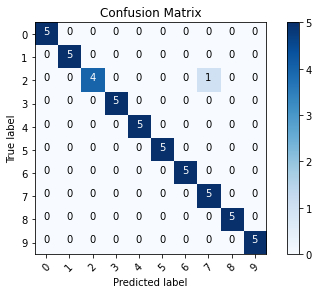

In [27]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
#ended the Youtube video at 2:38 pm https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org